In [20]:
from PIL import Image, ImageSequence
import imageio
import glob
import cv2

import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, palette='Set2')

Разобьём гифку на кадры. 

In [21]:
# im = Image.open("cartoon.gif")

# for idx, frame in enumerate(ImageSequence.Iterator(im)):
#     frame.save(f"./cartoon_framesa/frame_{idx}.png")

In [22]:
cartoon = [] 

for im_path in glob.glob("./cartoon_frames/*.png"):
    img = imageio.imread(im_path)
    img = cv2.resize(img, (55, 40))
    cartoon.append(img)
cartoon = np.array(cartoon)

In [23]:
cartoon.shape

(12, 40, 55, 4)

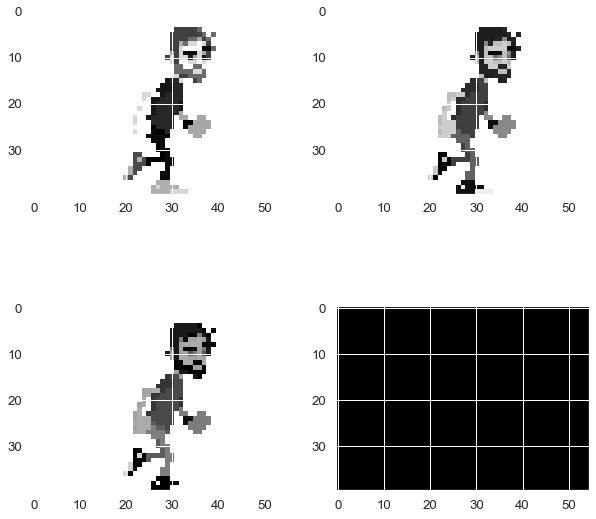

In [24]:
plt.figure(figsize=(10, 10))
plt.gray()

plt.subplot(2,2,1)
plt.imshow(cartoon[0, :, :, 0])

plt.subplot(2,2,2)
plt.imshow(cartoon[0, :, :, 1])

plt.subplot(2,2,3)
plt.imshow(cartoon[0, :, :, 2])

plt.subplot(2,2,4)
plt.imshow(cartoon[0, :, :, 3])


Уберём три канала цвета и сделаем ЧБ кадры. 

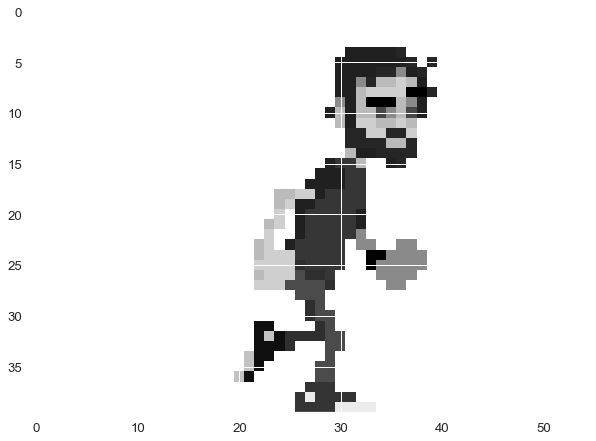

In [25]:
plt.figure(figsize=(10, 10))

plt.gray()

plt.imshow(cartoon[0, :, :, :-1].mean(axis=-1))

In [26]:
cartoon = cartoon[:,:,:,:-1].mean(axis=-1)
cartoon = np.tile(cartoon, (10, 1, 1))

In [27]:
cartoon.shape

(120, 40, 55)

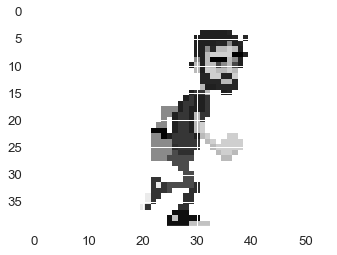

In [28]:
from IPython.display import clear_output

try: 
    for i in range(len(cartoon)):
        clear_output(True, )
        plt.imshow(cartoon[i])
        plt.show()
except:
    pass

Применим HOSVD к получившемуся тензору. 

In [30]:
from hottbox.core import Tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error

In [31]:
tensor = Tensor(cartoon.astype(float))
print(tensor)

This tensor is of order 3 and consists of 264000 elements.
Sizes and names of its modes are (120, 40, 55) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [32]:
alg = HOSVD()
alg

HOSVD(process=(), verbose=False)

In [33]:
ml_rank = (120, 10, 10)
tensor_tkd_hosvd = alg.decompose(tensor, ml_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_tkd_hosvd)

print('\n\tFactor matrices')
factor_matrices = {}
for mode, fmat in enumerate(tensor_tkd_hosvd.fmat):
    factor_matrices[mode] = fmat
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd_hosvd.core)

	Output of the HOSVD algorithm:
Tucker representation of a tensor with multi-linear rank=(120, 10, 10).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (120, 40, 55) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (120, 120)
Mode-1 factor matrix is of shape (40, 10)
Mode-2 factor matrix is of shape (55, 10)

	Core tensor
This tensor is of order 3 and consists of 12000 elements.
Sizes and names of its modes are (120, 10, 10) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [34]:
core = tensor_tkd_hosvd.core

In [36]:
core.shape, factor_matrices[0].shape, factor_matrices[1].shape, factor_matrices[2].shape

((120, 10, 10), (120, 120), (40, 10), (55, 10))

Восстановим изображение. 

In [38]:
init = (
    core
    .mode_n_product(factor_matrices[0], mode=0, inplace=False)
    .mode_n_product(factor_matrices[1], mode=1, inplace=False)
    .mode_n_product(factor_matrices[2], mode=2, inplace=False)
)


In [39]:
init.shape

(120, 40, 55)

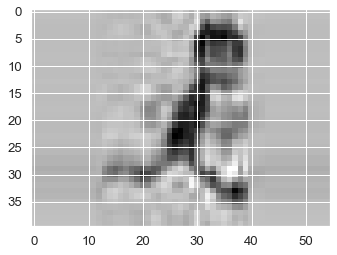

In [40]:
from IPython.display import clear_output

try:
    for i in range(len(init.data)):
        clear_output(True, )
        plt.imshow(init.data[i])
        plt.show()
except:
    pass

Смоделируем сигнал звука шагов

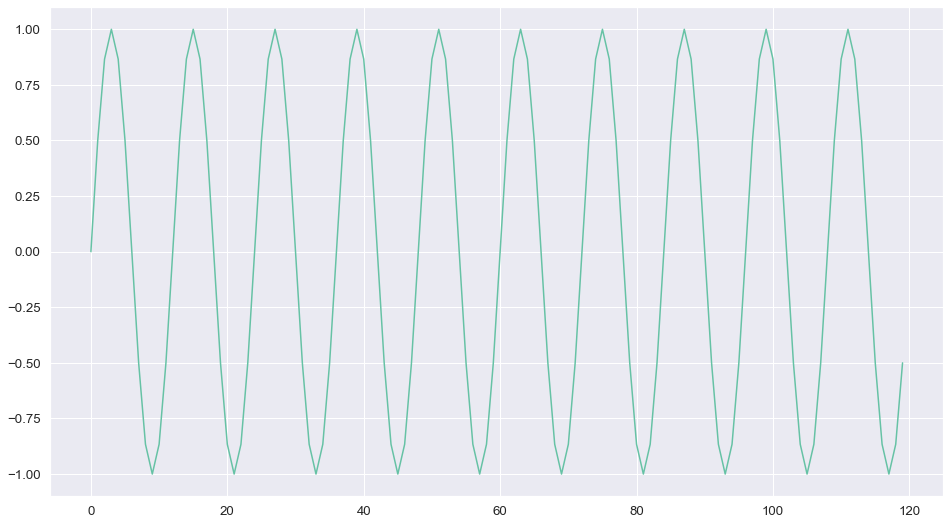

In [41]:
signal = np.sin(np.arange(120)*2*np.pi/12)


plt.figure(figsize=(16,9))
plt.plot(signal)

Построим траекторные матрицы/тензоры для звукового сигнала и последовательности кадров

In [45]:
trajectory_signal = np.array([signal[i:i+12] for i in range(len(signal)-11)])
trajectory_cartoon = np.array([init.data[i:i+12] for i in range(len(init.data)-11)])
# trajectory_cartoon = np.array([core.data[i:i+12] for i in range(len(core.data)-11)])

In [46]:
diffs_signal = np.array([
    [
        np.linalg.norm(trajectory_signal[i] - trajectory_signal[i+1]),
        np.linalg.norm(trajectory_signal[i] - trajectory_signal[i-1]),
    ]
    for i in range(1, len(trajectory_signal) - 1)
])
diffs_cartoon =np.array([
    [
        np.linalg.norm(trajectory_cartoon[i] - trajectory_cartoon[i+1]), 
        np.linalg.norm(trajectory_cartoon[i] - trajectory_cartoon[i-1]) 
    ]
    for i in range(1, len(trajectory_signal) - 1)
])

In [47]:
diffs_signal, diffs_cartoon

(array([[1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.26794919, 1.26794919],
        [1.267

In [49]:
L = diffs_signal[0, 0] / diffs_cartoon[0, 0]
print(L)

0.00019811764327178706


In [50]:
(diffs_signal / diffs_cartoon).max()

0.00019811764327178755